In [4]:
import cv2
import numpy as np

#since open CV 3.4.0, it can read darknet model by cv2.dnn.readNetFromDarknet
cv2.__version__

'3.4.10'

In [11]:
net = cv2.dnn.readNetFromDarknet("./cfg_mask/yolov3-tiny.cfg", "./cfg_mask/yolov3-tiny_47000.weights")

In [12]:
layer_names = net.getLayerNames()
print(layer_names)

['conv_0', 'bn_0', 'relu_1', 'pool_1', 'conv_2', 'bn_2', 'relu_3', 'pool_3', 'conv_4', 'bn_4', 'relu_5', 'pool_5', 'conv_6', 'bn_6', 'relu_7', 'pool_7', 'conv_8', 'bn_8', 'relu_9', 'pool_9', 'conv_10', 'bn_10', 'relu_11', 'pool_11', 'conv_12', 'bn_12', 'relu_13', 'conv_13', 'bn_13', 'relu_14', 'conv_14', 'bn_14', 'relu_15', 'conv_15', 'permute_16', 'yolo_16', 'identity_17', 'conv_18', 'bn_18', 'relu_19', 'upsample_19', 'concat_20', 'conv_21', 'bn_21', 'relu_22', 'conv_22', 'permute_23', 'yolo_23']


In [15]:
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
output_layers

['yolo_16', 'yolo_23']

In [16]:
# read classes
classes = [line.strip() for line in open("./cfg_mask/obj.names")]
colors = [(0,0,255),(255,0,0),(0,255,0)]

In [17]:
# read sample
from PIL import Image
Image.open("./data_image_mask/bladesu.jpg")

In [19]:
img = cv2.imread("./data_image_mask/bladesu.jpg")
img.shape

(1440, 2160, 3)

In [22]:
# resize to 416 X 416
height, width, channels = img.shape 
blob = cv2.dnn.blobFromImage(img, 1/255.0, (608, 608), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

In [23]:
len(outs)

2

In [24]:
class_ids = []
confidences = []
boxes = []
    
for out in outs:
    for detection in out:
        tx, ty, tw, th, confidence = detection[0:5]
        scores = detection[5:]
        class_id = np.argmax(scores)  
        if confidence > 0.3:   
            center_x = int(tx * width)
            center_y = int(ty * height)
            w = int(tw * width)
            h = int(th * height)
            
            # 取得箱子方框座標
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)


In [25]:
len(boxes)

2

In [27]:
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.4)

In [28]:
font = cv2.FONT_HERSHEY_PLAIN

for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = colors[class_ids[i]]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label, (x, y - 5), font, 2, color, 3)

In [29]:
img.shape


(1440, 2160, 3)

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


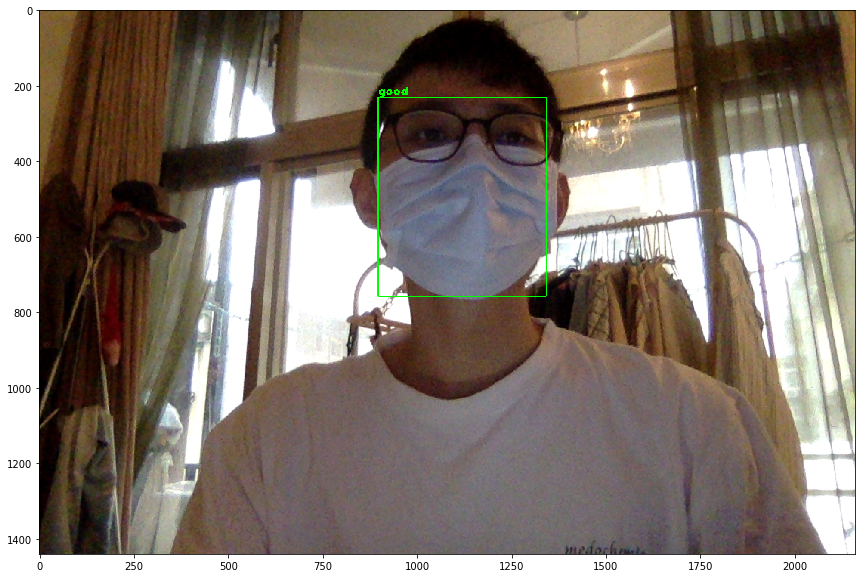

In [30]:
%pylab inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

In [32]:
# wrapper function
import cv2
import numpy as np
net = cv2.dnn.readNetFromDarknet("./cfg_mask/yolov3-tiny.cfg", "./cfg_mask/yolov3-tiny_47000.weights")
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
classes = [line.strip() for line in open("./cfg_mask/obj.names")]
colors = [(0,0,255),(255,0,0),(0,255,0)]

def yolo_detect(frame):
    # forward propogation
    img = cv2.resize(frame, None, fx=0.4, fy=0.4)
    height, width, channels = img.shape 
    # yolo v3
    # 320 x 320 (high speed, less accuracy)
    # 416 x 416 (moderate speed, moderate accuracy)
    # 608 x 608 (less speed, high accuracy)
    blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # get detection boxes
    class_ids = []
    confidences = []
    boxes = []
    
    for out in outs:
        for detection in out:
            tx, ty, tw, th, confidence = detection[0:5]
            scores = detection[5:]
            class_id = np.argmax(scores)  
            if confidence > 0.3:   
                center_x = int(tx * width)
                center_y = int(ty * height)
                w = int(tw * width)
                h = int(th * height)

                # 取得箱子方框座標
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                
    # draw boxes
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.4)
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[class_ids[i]]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label, (x, y -5), font, 3, color, 3)
    return img

In [5]:
img = cv2.imread("./data_image_mask/bladesu.jpg")
im = yolo_detect(img)
img_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

In [8]:
# wrapper function
import cv2
import numpy as np
net = cv2.dnn.readNetFromDarknet("./cfg_mask/yolov3-tiny.cfg", "./cfg_mask/yolov3-tiny_47000.weights")
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
classes = [line.strip() for line in open("./cfg_mask/obj.names")]
colors = [(0,0,255),(255,0,0),(0,255,0)]

def yolo_detect2(frame, dst):
    # forward propogation
    dst = cv2.resize(frame, None, fx=0.4, fy=0.4)
    height, width, channels = dst.shape 
    # yolo v3
    # 320 x 320 (high speed, less accuracy)
    # 416 x 416 (moderate speed, moderate accuracy)
    # 608 x 608 (less speed, high accuracy)
    blob = cv2.dnn.blobFromImage(dst, 1/255.0, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # redirect img to dst
    
    # get detection boxes
    class_ids = []
    confidences = []
    boxes = []
    
    for out in outs:
        for detection in out:
            tx, ty, tw, th, confidence = detection[0:5]
            scores = detection[5:]
            class_id = np.argmax(scores)  
            if confidence > 0.3:   
                center_x = int(tx * width)
                center_y = int(ty * height)
                w = int(tw * width)
                h = int(th * height)

                # 取得箱子方框座標
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                
    # draw boxes
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.4)
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[class_ids[i]]
            cv2.rectangle(dst, (x, y), (x + w, y + h), color, 2)
            cv2.putText(dst, label, (x, y -5), font, 3, color, 3)
    return dst

In [9]:
from matplotlib import pyplot as plt

img = cv2.imread("./data_image_mask/bladesu.jpg")
dst = np.ndarray(shape=img.shape, dtype=np.uint8)

dst = yolo_detect2(img1, dst)
img_rgb = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)